# Replication code for "Evaluating interdisciplinary research"

In [1]:
library(dplyr, quietly = TRUE)
library(ggplot2)
library(grid)
library(gridExtra)
library(gtools)
library(margins)
library(marginaleffects)
library(scales)
library(stargazer, quietly = TRUE)
library(tidyr, quietly = TRUE)
options(warn=-1)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine



Please cite as: 


 Hlavac, Marek (2022). stargazer: Well-Formatted Regression and Summary Statistics Tables.

 R package version 5.2.3. https://CRAN.R-project.org/package=stargazer 




In [2]:
# Reading in data
# Note that for anonymization purposes, interdisciplinarity measures are standardized with normally distributed noise,
# 1% of binary outcomes are flipped, and covariates are quintiled.

subs_df <- read.csv("subs_anon.csv")  # Submissions
revs_df <- read.csv("revs_anon.csv")  # Reviews

## Table 1: Descriptive statistics & correlations

In [3]:
summary(subs_df)

 manuscript_id        journal          journal_type       manuscript_type   
 Length:128950      Length:128950      Length:128950      Length:128950     
 Class :character   Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character   Mode  :character  
                                                                            
                                                                            
                                                                            
                                                                            
     year           topic_interdis        kb_interdis         teamsize_quintile
 Length:128950      Min.   :-1.9000000   Min.   :-3.1000000   Min.   :1.000    
 Class :character   1st Qu.:-0.9000000   1st Qu.:-0.6000000   1st Qu.:2.000    
 Mode  :character   Median : 0.2000000   Median : 0.1000000   Median :3.000    
                    Mean   :-0.0005522   Mean   :-0.0002458   Me

In [4]:
subs_df %>%
    select(topic_interdis, kb_interdis, teamsize_quintile, maxcites_quintile, numrefs_quintile, prevpubs_quintile) %>%
    drop_na() %>%
    cor()

,topic_interdis,kb_interdis,teamsize_quintile,maxcites_quintile,numrefs_quintile,prevpubs_quintile
topic_interdis,1.000000000,0.55805481,0.02661007,0.01245804,-0.03047738,0.007194451
kb_interdis,0.558054811,1.00000000,0.08366945,0.04433752,0.03446618,0.027455510
teamsize_quintile,0.026610065,0.08366945,1.00000000,0.46822392,0.13468870,0.466091723
maxcites_quintile,0.012458035,0.04433752,0.46822392,1.00000000,0.12445221,0.913993733
numrefs_quintile,-0.030477383,0.03446618,0.13468870,0.12445221,1.00000000,0.079278165
prevpubs_quintile,0.007194451,0.02745551,0.46609172,0.91399373,0.07927817,1.000000000


## Table 2: Logistic regression, final decision

In [5]:
mod1 <- glm(final_decision ~ topic_interdis,
    family = binomial(link="logit"),
    data=subs_df)
mod2 <- glm(final_decision ~ kb_interdis,
    family = binomial(link="logit"),
    data=subs_df)
mod3 <- glm(final_decision ~ topic_interdis + journal + manuscript_type + as.factor(year) + as.factor(teamsize_quintile) + as.factor(maxcites_quintile) + as.factor(numrefs_quintile) + as.factor(prevpubs_quintile),
    family = binomial(link="logit"),
    control=glm.control(maxit=50),
    data=subs_df)
mod4 <- glm(final_decision ~ kb_interdis + journal + manuscript_type + as.factor(year) + as.factor(teamsize_quintile) + as.factor(maxcites_quintile) + as.factor(numrefs_quintile) + as.factor(prevpubs_quintile),
    family = binomial(link="logit"),
    control=glm.control(maxit=50),
    data=subs_df)
mod5 <- glm(final_decision ~ topic_interdis + kb_interdis + journal + manuscript_type + as.factor(year) + as.factor(teamsize_quintile) + as.factor(maxcites_quintile) + as.factor(numrefs_quintile) + as.factor(prevpubs_quintile),
    family = binomial(link="logit"),
    control=glm.control(maxit=50),
    data=subs_df)
mod6 <- glm(final_decision ~ topic_interdis*kb_interdis + journal + manuscript_type + as.factor(year) + as.factor(teamsize_quintile) + as.factor(maxcites_quintile) + as.factor(numrefs_quintile) + as.factor(prevpubs_quintile),
    family = binomial(link="logit"),
    control=glm.control(maxit=50),
    data=subs_df)

stargazer(mod1,mod2,mod3,mod4,mod5,mod6,
          apply.coef = exp, # Uncomment for ORs
          ci = TRUE,  # Uncomment for OR CIs (have to use CIs b/c SEs will be incorrect)
          type = "text",
          title="Logistic regression: Final decision",
          align = TRUE,
          dep.var.labels = c("Final decision"),
          no.space = TRUE,
          omit = c("journal", "manuscript_type", "as.factor.year", "as.factor.teamsize_quintile", "as.factor.maxcites_quintile", "as.factor.numrefs_quintile", "as.factor.prevpubs_quintile"),
          covariate.labels = c("Constant","Topic ID", "Knowledgebase ID", "Topic ID:Knowledgebase ID"),
          intercept.bottom = FALSE,
          digits = 3,
          digits.extra = 0)

# Saving coefficients to plot
fd_coef_3 <- coef(mod3)["topic_interdis"]
fd_stderr_3 <- summary(mod3)$coef["topic_interdis", "Std. Error"]
fd_coef_4 <- coef(mod4)["kb_interdis"]
fd_stderr_4 <- summary(mod4)$coef["kb_interdis", "Std. Error"]


Logistic regression: Final decision
                                                                 Dependent variable:                                       
                          -------------------------------------------------------------------------------------------------
                                                                   Final decision                                          
                               (1)            (2)             (3)              (4)              (5)              (6)       
---------------------------------------------------------------------------------------------------------------------------
Constant                     1.153***       1.153***       38.870***        34.908***        35.686***        34.183***    
                          (1.142, 1.164) (1.142, 1.164) (36.884, 40.856) (32.922, 36.895) (33.700, 37.673) (32.197, 36.169)
Topic ID                     0.960***                       0.946***                          0

In [6]:
margins_topic <- margins(mod3, variables = "topic_interdis")
margins_kb <- margins(mod4, variables = "kb_interdis")
print(summary(margins_topic))
print(summary(margins_kb))

         factor     AME SE  z  p lower upper
 topic_interdis -0.0120 NA NA NA    NA    NA
      factor    AME SE  z  p lower upper
 kb_interdis 0.0090 NA NA NA    NA    NA


## Table 3: Logistic regression, review positivity

In [7]:
mod1 <- glm(review_positivity ~ topic_interdis,
    family = binomial(link="logit"),
    data=revs_df)
mod2 <- glm(review_positivity ~ kb_interdis,
    family = binomial(link="logit"),
    data=revs_df)
mod3 <- glm(review_positivity ~ topic_interdis + journal + manuscript_type + as.factor(year) + as.factor(teamsize_quintile) + as.factor(maxcites_quintile) + as.factor(numrefs_quintile) + as.factor(prevpubs_quintile),
    family = binomial(link="logit"),
    control=glm.control(maxit=50),
    data=revs_df)
mod4 <- glm(review_positivity ~ kb_interdis + journal + manuscript_type + as.factor(year) + as.factor(teamsize_quintile) + as.factor(maxcites_quintile) + as.factor(numrefs_quintile) + as.factor(prevpubs_quintile),
    family = binomial(link="logit"),
    control=glm.control(maxit=50),
    data=revs_df)
mod5 <- glm(review_positivity ~ topic_interdis + kb_interdis + journal + manuscript_type + as.factor(year) + as.factor(teamsize_quintile) + as.factor(maxcites_quintile) + as.factor(numrefs_quintile) + as.factor(prevpubs_quintile),
    family = binomial(link="logit"),
    control=glm.control(maxit=50),
    data=revs_df)
mod6 <- glm(review_positivity ~ topic_interdis*kb_interdis + journal + manuscript_type + as.factor(year) + as.factor(teamsize_quintile) + as.factor(maxcites_quintile) + as.factor(numrefs_quintile) + as.factor(prevpubs_quintile),
    family = binomial(link="logit"),
    control=glm.control(maxit=50),
    data=revs_df)

stargazer(mod1,mod2,mod3,mod4,mod5,mod6, 
          apply.coef = exp, # Uncomment for ORs
          ci = TRUE,  # Uncomment for ORs (have to use CIs b/c SEs will be incorrect)
          type = "text",
          title="Logistic regression: Review positivity",
          align = TRUE,
          dep.var.labels = c("Review positivity"),
          no.space = TRUE,
          omit = c("journal", "manuscript_type", "as.factor.year", "as.factor.teamsize_quintile", "as.factor.maxcites_quintile", "as.factor.numrefs_quintile", "as.factor.prevpubs_quintile"),
          covariate.labels = c("Constant","Topic ID", "Knowledgebase ID", "Topic ID:Knowledgebase ID"),
          intercept.bottom = FALSE,
          digits = 3,
          digits.extra = 0)

# Saving coefficients to plot
rp_coef_3 <- coef(mod3)["topic_interdis"]
rp_stderr_3 <- summary(mod3)$coef["topic_interdis", "Std. Error"]
rp_coef_4 <- coef(mod4)["kb_interdis"]
rp_stderr_4 <- summary(mod4)$coef["kb_interdis", "Std. Error"]


Logistic regression: Review positivity
                                                                 Dependent variable:                                       
                          -------------------------------------------------------------------------------------------------
                                                                  Review positivity                                        
                               (1)            (2)             (3)              (4)              (5)              (6)       
---------------------------------------------------------------------------------------------------------------------------
Constant                     3.866***       3.869***       22.042***        20.180***        20.528***        20.076***    
                          (3.855, 3.877) (3.858, 3.880) (21.298, 22.787) (19.435, 20.924) (19.784, 21.273) (19.331, 20.821)
Topic ID                     0.990***                       0.976***                        

## Figure 1: Interdisciplinarity vs. review outcomes

In [8]:
# Monodisciplinary and interdisciplinary journal models
mono_subs_df <- subset(subs_df, journal_type == "Monodisciplinary")
interdis_subs_df <- subset(subs_df, journal_type == "Interdisciplinary")
mono_revs_df <- subset(revs_df, journal_type == "Monodisciplinary")
interdis_revs_df <- subset(revs_df, journal_type == "Interdisciplinary")

mod_mono_3_fd <- glm(final_decision ~ topic_interdis + journal + manuscript_type + as.factor(year) + as.factor(teamsize_quintile) + as.factor(maxcites_quintile) + as.factor(numrefs_quintile) + as.factor(prevpubs_quintile),
    family = binomial(link="logit"),
    control=glm.control(maxit=50),
    data=mono_subs_df)

mod_mono_3_rp <- glm(review_positivity ~ topic_interdis + journal + manuscript_type + as.factor(year) + as.factor(teamsize_quintile) + as.factor(maxcites_quintile) + as.factor(numrefs_quintile) + as.factor(prevpubs_quintile),
    family = binomial(link="logit"),
    control=glm.control(maxit=50),
    data=mono_revs_df)

mod_mono_4_fd <- glm(final_decision ~ kb_interdis + journal + manuscript_type + as.factor(year) + as.factor(teamsize_quintile) + as.factor(maxcites_quintile) + as.factor(numrefs_quintile) + as.factor(prevpubs_quintile),
    family = binomial(link="logit"),
    control=glm.control(maxit=50),
    data=mono_subs_df)

mod_mono_4_rp <- glm(review_positivity ~ kb_interdis + journal + manuscript_type + as.factor(year) + as.factor(teamsize_quintile) + as.factor(maxcites_quintile) + as.factor(numrefs_quintile) + as.factor(prevpubs_quintile),
    family = binomial(link="logit"),
    control=glm.control(maxit=50),
    data=mono_revs_df)

mod_interdis_3_fd <- glm(final_decision ~ topic_interdis + journal + manuscript_type + as.factor(year) + as.factor(teamsize_quintile) + as.factor(maxcites_quintile) + as.factor(numrefs_quintile) + as.factor(prevpubs_quintile),
    family = binomial(link="logit"),
    control=glm.control(maxit=50),
    data=interdis_subs_df)

mod_interdis_3_rp <- glm(review_positivity ~ topic_interdis + journal + manuscript_type + as.factor(year) + as.factor(teamsize_quintile) + as.factor(maxcites_quintile) + as.factor(numrefs_quintile) + as.factor(prevpubs_quintile),
    family = binomial(link="logit"),
    control=glm.control(maxit=50),
    data=interdis_revs_df)

mod_interdis_4_fd <- glm(final_decision ~ kb_interdis + journal + manuscript_type + as.factor(year) + as.factor(teamsize_quintile) + as.factor(maxcites_quintile) + as.factor(numrefs_quintile) + as.factor(prevpubs_quintile),
    family = binomial(link="logit"),
    control=glm.control(maxit=50),
    data=interdis_subs_df)

mod_interdis_4_rp <- glm(review_positivity ~ kb_interdis + journal + manuscript_type + as.factor(year) + as.factor(teamsize_quintile) + as.factor(maxcites_quintile) + as.factor(numrefs_quintile) + as.factor(prevpubs_quintile),
    family = binomial(link="logit"),
    control=glm.control(maxit=50),
    data=interdis_revs_df)

mono_3_fd_coef <- coef(mod_mono_3_fd)["topic_interdis"]
mono_3_rp_coef <- coef(mod_mono_3_rp)["topic_interdis"]
mono_4_fd_coef <- coef(mod_mono_4_fd)["kb_interdis"]
mono_4_rp_coef <- coef(mod_mono_4_rp)["kb_interdis"]
interdis_3_fd_coef <- coef(mod_interdis_3_fd)["topic_interdis"]
interdis_3_rp_coef <- coef(mod_interdis_3_rp)["topic_interdis"]
interdis_4_fd_coef <- coef(mod_interdis_4_fd)["kb_interdis"]
interdis_4_rp_coef <- coef(mod_interdis_4_rp)["kb_interdis"]

mono_3_fd_stderr <- summary(mod_mono_3_fd)$coef["topic_interdis", "Std. Error"]
mono_3_rp_stderr <- summary(mod_mono_3_rp)$coef["topic_interdis", "Std. Error"]
mono_4_fd_stderr <- summary(mod_mono_4_fd)$coef["kb_interdis", "Std. Error"]
mono_4_rp_stderr <- summary(mod_mono_4_rp)$coef["kb_interdis", "Std. Error"]
interdis_3_fd_stderr <- summary(mod_interdis_3_fd)$coef["topic_interdis", "Std. Error"]
interdis_3_rp_stderr <- summary(mod_interdis_3_rp)$coef["topic_interdis", "Std. Error"]
interdis_4_fd_stderr <- summary(mod_interdis_4_fd)$coef["kb_interdis", "Std. Error"]
interdis_4_rp_stderr <- summary(mod_interdis_4_rp)$coef["kb_interdis", "Std. Error"]

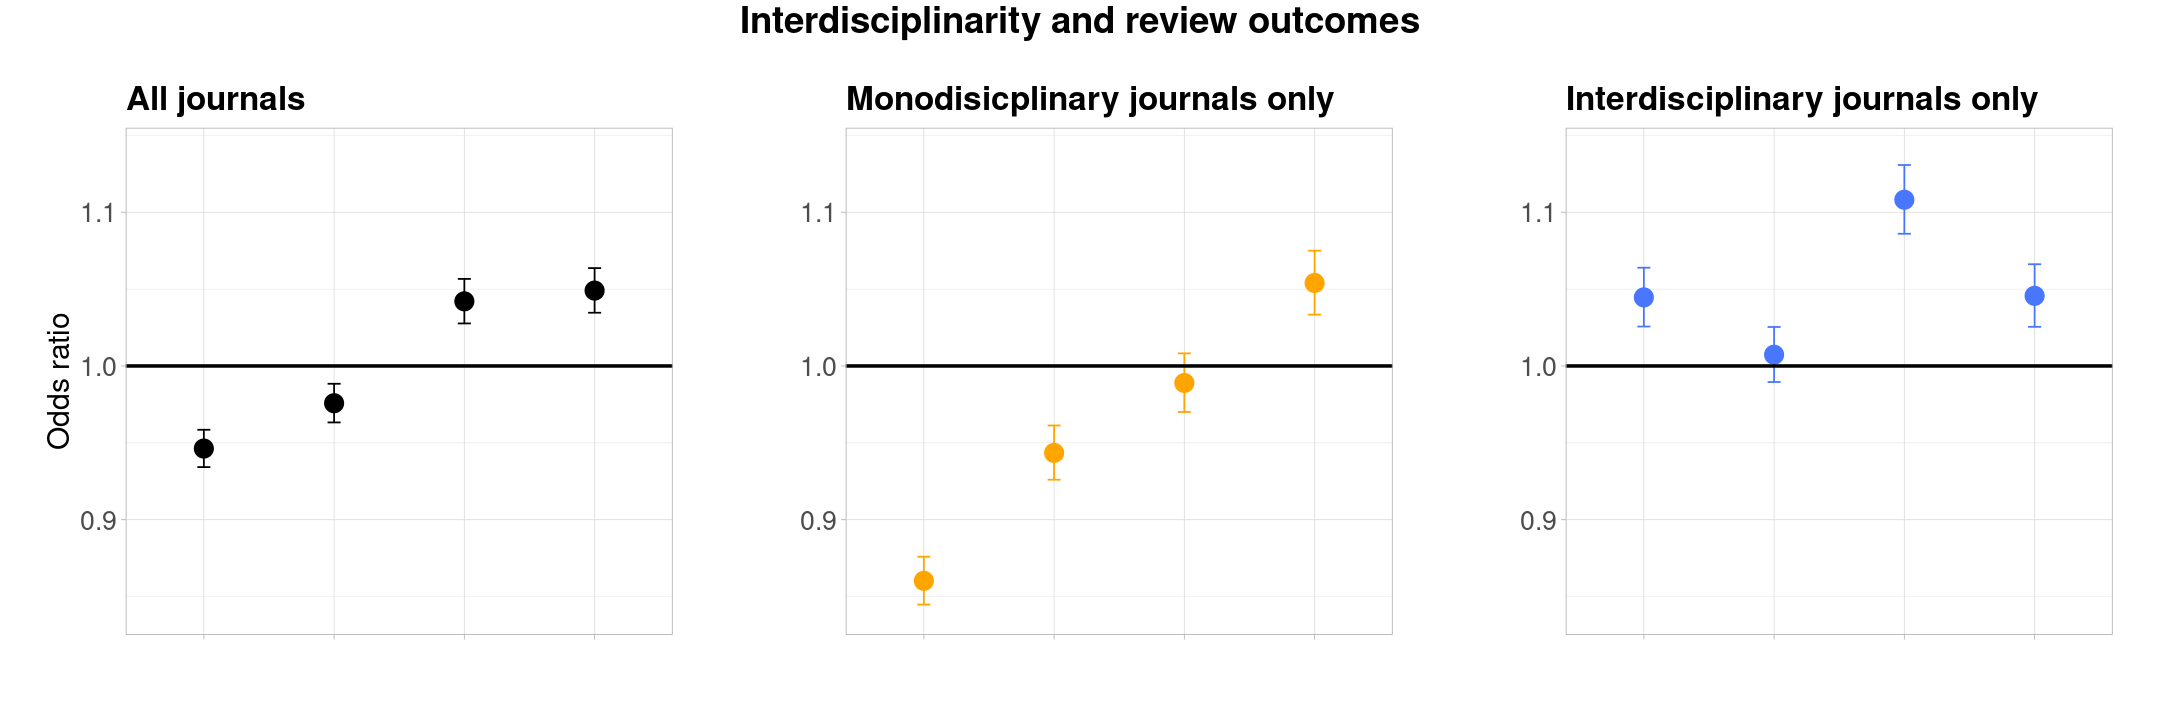

In [9]:
# Create dfs for plotting
coef_df <- data.frame(
    model = c("Topic, Final decision", "Topic, Review positivity", "Knowledge-base, Final decision", "Knowledge-base, Review positivity"),
    coefficient = c(fd_coef_3, rp_coef_3, fd_coef_4, rp_coef_4),
    odds_ratio = exp(c(fd_coef_3, rp_coef_3, fd_coef_4, rp_coef_4)),
    error = c(fd_stderr_3, rp_stderr_3, fd_stderr_4, rp_stderr_4),
    journals = "All"
)
coef_df$model <- factor(coef_df$model, levels = c("Topic, Final decision", "Topic, Review positivity", "Knowledge-base, Final decision", "Knowledge-base, Review positivity"))

coef_df_mono <- data.frame(
    model = c("Topic, Final decision", "Topic, Review positivity", "Knowledge-base, Final decision", "Knowledge-base, Review positivity"),
    coefficient = c(mono_3_fd_coef, mono_3_rp_coef, mono_4_fd_coef, mono_4_rp_coef),
    odds_ratio = exp(c(mono_3_fd_coef, mono_3_rp_coef, mono_4_fd_coef, mono_4_rp_coef)),
    error = c(mono_3_fd_stderr, mono_3_rp_stderr, mono_4_fd_stderr, mono_4_rp_stderr),
    journals = "Monodisciplinary"
)
coef_df_mono$model <- factor(coef_df_mono$model, levels = c("Topic, Final decision", "Topic, Review positivity", "Knowledge-base, Final decision", "Knowledge-base, Review positivity"))

coef_df_int <- data.frame(
    model = c("Topic, Final decision", "Topic, Review positivity", "Knowledge-base, Final decision", "Knowledge-base, Review positivity"),
    coefficient = c(interdis_3_fd_coef, interdis_3_rp_coef, interdis_4_fd_coef, interdis_4_rp_coef),
    odds_ratio = exp(c(interdis_3_fd_coef, interdis_3_rp_coef, interdis_4_fd_coef, interdis_4_rp_coef)),
    error = c(interdis_3_fd_stderr, interdis_3_rp_stderr, interdis_4_fd_stderr, interdis_4_rp_stderr),
    journals = "Interdisciplinary"
)
coef_df_int$model <- factor(coef_df_int$model, levels = c("Topic, Final decision", "Topic, Review positivity", "Knowledge-base, Final decision", "Knowledge-base, Review positivity"))


# Plotting
ymin <- 0.84
ymax <- 1.14

options(repr.plot.width = 18,repr.plot.height = 6)

plot1 <- ggplot(data=coef_df, aes(x=model, y=odds_ratio)) + 
    geom_point(size=5, color="black") +
    geom_errorbar(aes(ymin=exp(coefficient - (1.96*error)), max = exp(coefficient + (1.96*error))), width = 0.1, color="black") +
    geom_hline(yintercept = 1, color = "black", size = 1) +
    ylim(ymin, ymax) +
    labs(title = "All journals",
         x = "",
         y= "Odds ratio") +
    theme_light() +
    theme(#axis.text.x = element_text(angle = 30, hjust = 1, size = 16),
          axis.text.x = element_blank(),
          axis.text.y = element_text(size = 16),
          axis.title = element_text(size = 18),
          legend.text = element_text(size = 14),
          legend.title = element_text(size = 14),
          plot.title = element_text(size = 20, face = "bold"),
          plot.margin = unit(c(1, 1, 1, 1), "cm")
    )

plot2 <- ggplot(data=coef_df_mono, aes(x=model, y=odds_ratio)) + 
    geom_point(size=5, color="orange1") +
    geom_errorbar(aes(ymin=exp(coefficient - (1.96*error)), max = exp(coefficient + (1.96*error))), width = 0.1, color="orange1") +
    geom_hline(yintercept = 1, color = "black", size = 1) +
    ylim(ymin, ymax) +
    labs(title = "Monodisicplinary journals only",
         x = "",
         y= "") +
    theme_light() +
    theme(#axis.text.x = element_text(angle = 30, hjust = 1, size = 16),
          axis.text.x = element_blank(),
          axis.text.y = element_text(size = 16),
          axis.title = element_text(size = 18),
          legend.text = element_text(size = 14),
          legend.title = element_text(size = 14),
          plot.title = element_text(size = 20, face = "bold"),
          plot.margin = unit(c(1, 1, 1, 1), "cm")
    )

plot3 <- ggplot(data=coef_df_int, aes(x=model, y=odds_ratio)) + 
    geom_point(size=5, color="royalblue1") +
    geom_errorbar(aes(ymin=exp(coefficient - (1.96*error)), max = exp(coefficient + (1.96*error))), width = 0.1, color="royalblue1") +
    geom_hline(yintercept = 1, color = "black", size = 1) +
    ylim(ymin, ymax) +
    labs(title = "Interdisciplinary journals only",
         x = "",
         y= "") +
    theme_light() +
    theme(#axis.text.x = element_text(angle = 30, hjust = 1, size = 16),
          axis.text.x = element_blank(),
          axis.text.y = element_text(size = 16),
          axis.title = element_text(size = 18),
          legend.text = element_text(size = 14),
          legend.title = element_text(size = 14),
          plot.title = element_text(size = 20, face = "bold"),
          plot.margin = unit(c(1, 1, 1, 1), "cm")
    )

g <- arrangeGrob(plot1, plot2, plot3, ncol=3,
            top=textGrob("Interdisciplinarity and review outcomes",
                         gp=gpar(fontsize=22,
                                 fontface="bold")))

grid.draw(g)

## Figure 2: Interaction

In [10]:
mod6 <- glm(final_decision ~ topic_interdis*kb_interdis + journal + manuscript_type + as.factor(year) + as.factor(teamsize_quintile) + as.factor(maxcites_quintile) + as.factor(numrefs_quintile) + as.factor(prevpubs_quintile),
    family = binomial(link="logit"),
    control=glm.control(maxit=50),
    data=subs_df)

p1 <- plot_predictions(mod6,
                       condition=list('topic_interdis',
                                   'kb_interdis' = 'threenum'),
                       draw = FALSE)
p2 <- plot_predictions(mod6,
                       condition=list('kb_interdis',
                                   'topic_interdis' = 'threenum'),
                       draw = FALSE)

Scale for linetype is already present.
Adding another scale for linetype, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Scale for linetype is already present.
Adding another scale for linetype, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


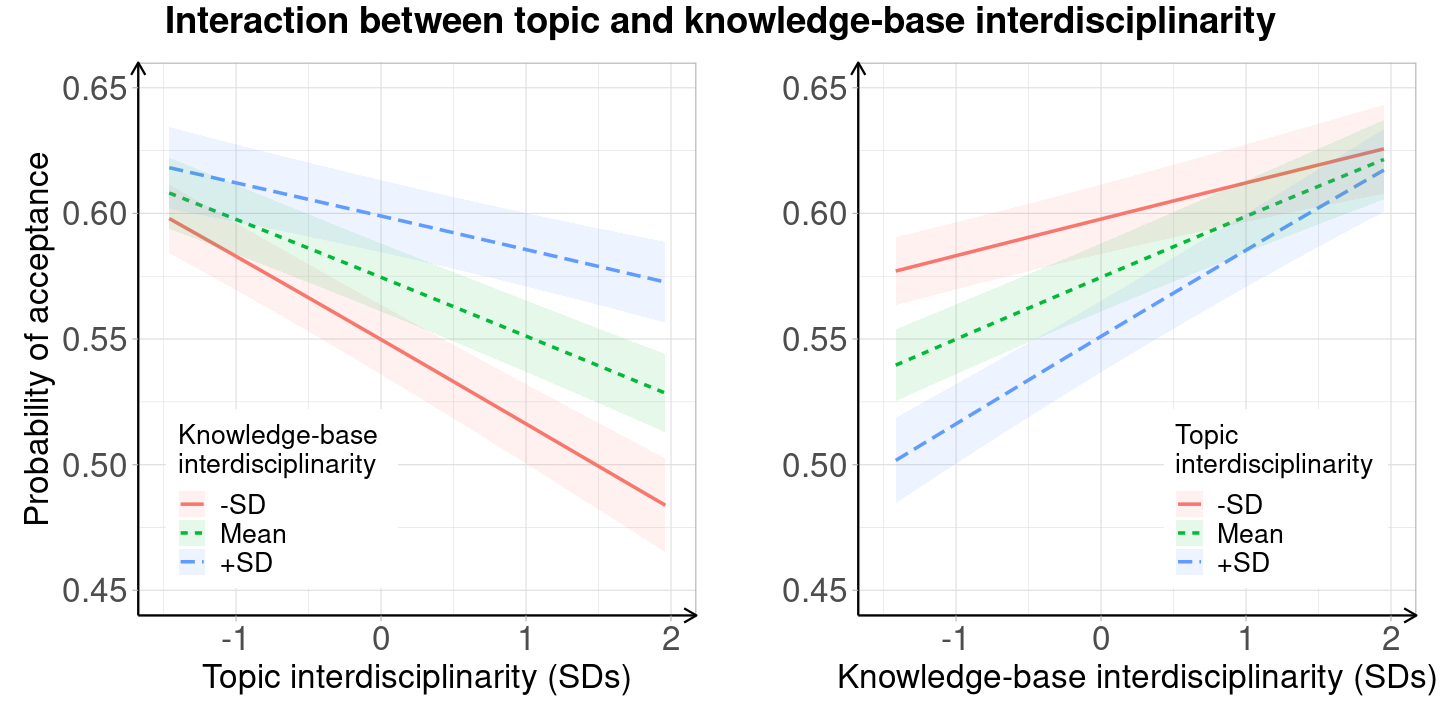

In [13]:
# Plotting

labels <- c('-SD', 'Mean', '+SD')
options(repr.plot.width=12, repr.plot.height=6)

ylims <- c(0.45, 0.65)
breaks <- seq(0.45, 0.65, 0.05)
xlims <- c(-1.5, 2)

# KBID as line
plot1 <- ggplot(p1, aes(x = topic_interdis, y = estimate,
            linetype = kb_interdis, color = kb_interdis, fill = kb_interdis)) +
            geom_line(size = 1) +
            #scale_linetype_manual(values = c("solid", "dashed", "dotted", "dotdash", "longdash")) +
            scale_linetype_manual(values = c("solid", "dashed", "dotted")) +
            #scale_color_manual(values = hue_pal()(5)) +
            scale_color_manual(values = hue_pal()(3)) +
            geom_ribbon(aes(ymin = conf.low, ymax = conf.high), alpha = 0.1, color = NA) +
            #scale_fill_manual(values = hue_pal()(5)) +
            scale_fill_manual(values = hue_pal()(3)) +
            scale_linetype_discrete(labels = labels) +
            scale_color_discrete(labels = labels) +
            scale_fill_discrete(labels = labels) +
            scale_y_continuous(limits=ylims, breaks=breaks) +
            scale_x_continuous(limits=xlims) +
            theme_light(base_size = 14) +
            labs(
                  #title = "Predicted probabilities of acceptance",
                  #title = "Predicted probabilities of positive review",
                  x = "Topic interdisciplinarity (SDs)",
                  y = "Probability of acceptance",
                  #y = "Probability of positive review",
                  linetype = "Knowledge-base \ninterdisciplinarity",
                  color = "Knowledge-base \ninterdisciplinarity",
                  fill = "Knowledge-base \ninterdisciplinarity") +
            theme(axis.line.x = element_line(arrow = grid::arrow(length = unit(0.3, "cm"), ends = "last")),
                  axis.line.y = element_line(arrow = grid::arrow(length = unit(0.3, "cm"), ends = "last")),
                  axis.text.x = element_text(size = 20),
                  axis.text.y = element_text(size = 20),
                  axis.title = element_text(size = 20),
                  legend.text = element_text(size = 16),
                  legend.title = element_text(size = 16),
                  legend.position = c(0.05, 0.05),
                  legend.justification = c("left", "bottom"),
                  plot.margin = unit(c(0.5, 0.5, 0.5, 0.5), "cm"))

# TopID as line
plot2 <- ggplot(p2, aes(x = kb_interdis, y = estimate,
            linetype = topic_interdis, color = topic_interdis, fill = topic_interdis)) +
            geom_line(size = 1) +
            #scale_linetype_manual(values = c("solid", "dashed", "dotted", "dotdash", "longdash")) +
            scale_linetype_manual(values = c("solid", "dashed", "dotted")) +
            #scale_color_manual(values = hue_pal()(5)) +
            scale_color_manual(values = hue_pal()(3)) +
            geom_ribbon(aes(ymin = conf.low, ymax = conf.high), alpha = 0.1, color = NA) +
            #scale_fill_manual(values = hue_pal()(5)) +
            scale_fill_manual(values = hue_pal()(3)) +
            scale_linetype_discrete(labels = labels) +
            scale_color_discrete(labels = labels) +
            scale_fill_discrete(labels = labels) +
            scale_y_continuous(limits=ylims, breaks=breaks) +
            scale_x_continuous(limits=xlims) +
            theme_light(base_size = 14) +
            labs(
                  #title = "Predicted probabilities of acceptance",
                  #title = "Predicted probabilities of positive review",
                  x = "Knowledge-base interdisciplinarity (SDs)",
                  y = "",
                  #y = "Probability of positive review",
                  linetype = "Topic \ninterdisciplinarity",
                  color = "Topic \ninterdisciplinarity",
                  fill = "Topic \ninterdisciplinarity") +
            theme(axis.line.x = element_line(arrow = grid::arrow(length = unit(0.3, "cm"), ends = "last")),
                  axis.line.y = element_line(arrow = grid::arrow(length = unit(0.3, "cm"), ends = "last")),
                  axis.text.x = element_text(size = 20),
                  axis.text.y = element_text(size = 20),
                  axis.title = element_text(size = 20),
                  legend.text = element_text(size = 16),
                  legend.title = element_text(size = 16),
                  legend.position = c(0.95, 0.05),
                  legend.justification = c("right", "bottom"),
                  plot.margin = unit(c(0.5, 0.5, 0.5, 0.5), "cm"))

g <- arrangeGrob(plot1, plot2,
                 ncol=2,
                 top=textGrob("Interaction between topic and knowledge-base interdisciplinarity",
                             gp=gpar(fontsize=22,
                                     fontface="bold")))

grid.draw(g)